In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import re

# Task 1 - joining data

We start by copying code from HW3. It creates a cleaned data frame with total number of cell phones per year and country

In [2]:
# From HW3
# Function converting strings into numbers
def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan # not a number
    if isinstance(value, str):
        if value.endswith('k'):
            return float(value[:-1]) * 1e3 # thousand
        elif value.endswith('M'):
            return float(value[:-1]) * 1e6 # million
        elif value.endswith('B'):
            return float(value[:-1]) * 1e9 # billion
    return float(value)

In [3]:
# From HW3
# load data
cell_phones_total = pd.read_csv('cell_phones_total.csv')

# clean data:
# Convert all columns except for iso-3 using function defined in above cell
for col in cell_phones_total.columns[1:]:
    cell_phones_total.loc[:, col] = cell_phones_total[col].apply(convert_to_numeric)

# For empty values, set it to 0 if all columns to the left has a value of 0 or is empty. Else set it to nan
for i, col in enumerate(cell_phones_total.columns[1:], start=1):
    left_columns = cell_phones_total.iloc[:, 1:i]
    cell_phones_total.loc[cell_phones_total[col].isna() & (left_columns.fillna(0).sum(axis=1) == 0), col] = 0

Load the population per country and year into a dataframe and merge it with the number of cell phones

In [4]:
pop_data = pd.read_csv('pop_data.csv')

# melt the data
cell_phones_long = cell_phones_total.melt(
    id_vars=['iso-3'], var_name='year', value_name='cell_phones_total'
)
pop_data_long = pop_data.melt(
    id_vars=['iso-3'], var_name='year', value_name='population'
)

# Store the year as numeric
cell_phones_long['year'] = pd.to_numeric(cell_phones_long['year'], errors='coerce')
pop_data_long['year'] = pd.to_numeric(pop_data_long['year'], errors='coerce')

# Merge cell phones and population data
merged_data = pd.merge(cell_phones_long, pop_data_long, how='inner', on=['iso-3', 'year'])

Now we create the table as requested in the HW

In [5]:
# Generate the requested table
phone_population_table = merged_data.sort_values(
    ['year', 'iso-3'], ascending=[True, True]
).head(5)

print("First five phones and population combined:")
print(phone_population_table)

First five phones and population combined:
  iso-3  year  cell_phones_total  population
0   ABW  1960                0.0     54608.0
1   AFG  1960                0.0   8622466.0
2   AGO  1960                0.0   5357195.0
3   ALB  1960                0.0   1608800.0
4   AND  1960                0.0      9443.0


Load all the country codes into a data frame and merge it with the other data

In [6]:
country_data = pd.read_csv('country_data.csv')
# the country code is called iso-3 in the other file, change it to the same
country_data.rename(columns={'alpha-3': 'iso-3'}, inplace=True)

# Merge the prior data frame with the country data frame
merged_data_2 = pd.merge(merged_data, country_data, how='inner', on='iso-3')

Calculate phones per capita and pivot the data so we have countries as columns and year as rows

In [7]:
# Convert to numeric as we will do a calculation using this data
merged_data_2['cell_phones_total'] = pd.to_numeric(merged_data_2['cell_phones_total'], errors='coerce')
merged_data_2['population'] = pd.to_numeric(merged_data_2['population'], errors='coerce')

# Calculate phones per capita and store it in the data frame
merged_data_2['phones_per_capita'] = (
    merged_data_2['cell_phones_total'] / merged_data_2['population']
)

# Pivot
phones_per_capita = merged_data_2.pivot_table(
    index='year', columns='name', values='phones_per_capita'
).reset_index()

Find the countries with highest number of cell phones per capita in 2019.
Note that the table looks slightly different from the HW assgnment. Macao doesn't have cell phone data for 2019 and I choose to not include it due to that. In the HW assignment, I guess the data for 2018 was used instead.

In [8]:
# Data for 2019
data_2019 = merged_data_2[merged_data_2['year'] == 2019]

# Filter out missing data
data_2019_cleaned = data_2019.dropna(subset=['phones_per_capita'])

# Get the top 5 countries with highest 'phones_per_capita' in 2019
top_5_countries = data_2019_cleaned.nlargest(5, 'phones_per_capita')[['name', 'phones_per_capita']]

top_5_countries


,name,phones_per_capita
4591,Hong Kong,2.863650
335,United Arab Emirates,2.127739
10247,Seychelles,1.987196
7223,Montenegro,1.848791
10527,Thailand,1.823083


Generate the table requested in the HW assigment

In [9]:
# Filter on requested years
data_2015_2019 = merged_data_2[merged_data_2['year'].between(2015, 2019)]

# Keep only the top 5 counties
data_top_5_countries = data_2015_2019[data_2015_2019['name'].isin(top_5_countries['name'])]

# Pivot
phones_per_capita_top_5 = data_top_5_countries.pivot_table(
    index='year', columns='name', values='phones_per_capita'
).reset_index()

phones_per_capita_top_5


name,year,Hong Kong,Montenegro,Seychelles,Thailand,United Arab Emirates
0,2015,2.290401,1.623379,1.584260,1.465266,2.007424
1,2016,2.398931,1.671212,1.605459,1.699547,2.212521
2,2017,2.488773,1.671024,1.742433,1.720777,2.183431
3,2018,2.670209,1.816057,1.849900,1.757400,2.199084
4,2019,2.863650,1.848791,1.987196,1.823083,2.127739


Create a plot that illustrates the growth rate of the countries in the table above over the last 10 years

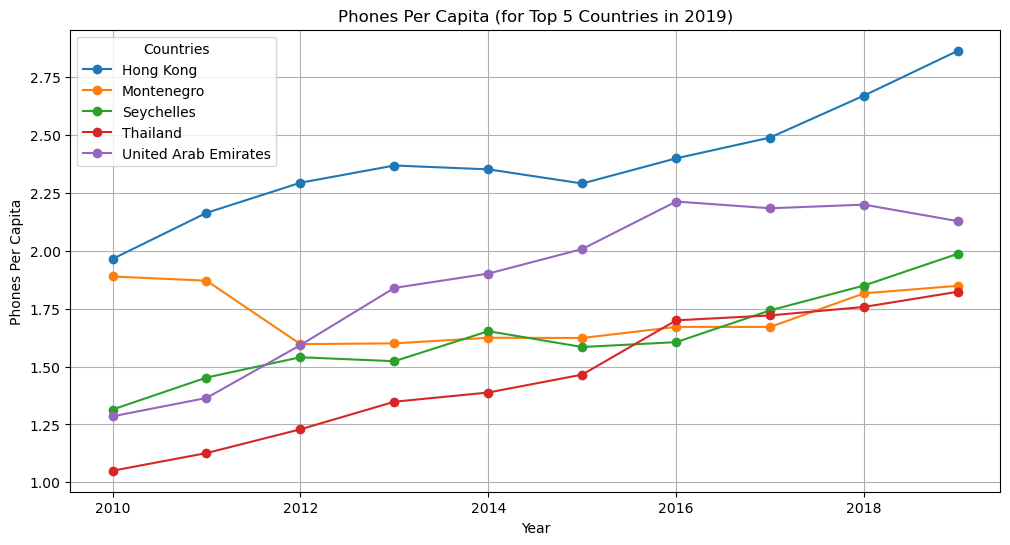

In [10]:
# 10 years of data
data_2010_2019 = merged_data_2[merged_data_2['year'].between(2010, 2019)]
data_top_5_countries_10_years = data_2010_2019[data_2010_2019['name'].isin(top_5_countries['name'])]

# pivot
data_top_5_countries_10_years_pivot = data_top_5_countries_10_years.pivot_table(
    index='year', columns='name', values='phones_per_capita'
)

# Plot it
plt.figure(figsize=(12, 6))
for country in data_top_5_countries_10_years_pivot.columns:
    plt.plot(
        data_top_5_countries_10_years_pivot.index,
        data_top_5_countries_10_years_pivot[country],
        label=country,
        marker='o'
    )

plt.title("Phones Per Capita (for Top 5 Countries in 2019)")
plt.xlabel("Year")
plt.ylabel("Phones Per Capita")
plt.legend(title="Countries")
plt.grid(True)
plt.show()


In the graph we see that Hong Kong is the undisputed number 1 country and has kept the number one position during the entire timespan. Phones Per Capita is also growing fast there.

For 2019 the number 2 country is UAE and it has been growing fast, especially during the first half of the time period. From 2019 and onwards the growth has been stagnant.

Thailand is the only country(out of these five) where the growth rate always has been positive in the time range.


# Task 2 - sql

Connect to the db and analyse the database

In [11]:
conn = sql.connect("user_actions.db")
cursor = conn.cursor()

# check what tables we have
list(cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"))

[('user_actions',)]

In [12]:
# check columns for the table user_actions
list(cursor.execute("SELECT * FROM PRAGMA_TABLE_INFO('user_actions');"))

[(0, 'user_id', 'INTEGER', 0, None, 0),
 (1, 'username', 'TEXT', 0, None, 0),
 (2, 'email', 'TEXT', 0, None, 0),
 (3, 'action', 'TEXT', 0, None, 0),
 (4, 'timestamp', 'TEXT', 0, None, 0)]

In [13]:
# how many rows do we have in the table user_actions?
list(cursor.execute("SELECT count(*) FROM user_actions;"))

[(8040,)]

Now that we undertand the schema and how much data we have, we can answer the questions.

Retrieve the usernames of all users who have performed the "signup" action


In [14]:
query = """
SELECT
    username 
FROM
    user_actions
WHERE
    action='signup'
ORDER BY
    username;
"""

list(cursor.execute(query))

[('user1',),
 ('user10',),
 ('user11',),
 ('user12',),
 ('user13',),
 ('user14',),
 ('user15',),
 ('user16',),
 ('user17',),
 ('user18',),
 ('user19',),
 ('user2',),
 ('user20',),
 ('user21',),
 ('user22',),
 ('user23',),
 ('user24',),
 ('user25',),
 ('user26',),
 ('user27',),
 ('user28',),
 ('user29',),
 ('user3',),
 ('user30',),
 ('user31',),
 ('user32',),
 ('user33',),
 ('user34',),
 ('user35',),
 ('user4',),
 ('user5',),
 ('user6',),
 ('user7',),
 ('user8',),
 ('user9',)]

Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.


In [15]:
query = """
SELECT
    user_id,
    username,
    COUNT(*) 
FROM
    user_actions
GROUP BY
    user_id
ORDER BY
    user_id;
"""

list(cursor.execute(query))

[(1, 'user1', 104),
 (2, 'user2', 149),
 (3, 'user3', 108),
 (4, 'user4', 436),
 (5, 'user5', 192),
 (6, 'user6', 457),
 (7, 'user7', 362),
 (8, 'user8', 329),
 (9, 'user9', 118),
 (10, 'user10', 170),
 (11, 'user11', 328),
 (12, 'user12', 209),
 (13, 'user13', 470),
 (14, 'user14', 320),
 (15, 'user15', 35),
 (16, 'user16', 379),
 (17, 'user17', 367),
 (18, 'user18', 122),
 (19, 'user19', 58),
 (20, 'user20', 362),
 (21, 'user21', 323),
 (22, 'user22', 275),
 (23, 'user23', 309),
 (24, 'user24', 162),
 (25, 'user25', 136),
 (26, 'user26', 217),
 (27, 'user27', 211),
 (28, 'user28', 91),
 (29, 'user29', 49),
 (30, 'user30', 165),
 (31, 'user31', 389),
 (32, 'user32', 32),
 (33, 'user33', 32),
 (34, 'user34', 180),
 (35, 'user35', 394)]

Identify users who have both logged in (action = 'login') and signed up (action = 'signup') on the same day.
Display the user_id and username.

In [16]:


query = """
SELECT
    ua1.user_id,
    ua1.username
FROM
    user_actions ua1
JOIN
    user_actions ua2 ON
        ua1.user_id = ua2.user_id AND 
        DATE(ua1.timestamp) = DATE(ua2.timestamp) AND 
        ua1.action = 'login' AND
        ua2.action = 'signup'
ORDER BY
    ua1.user_id
"""

list(cursor.execute(query))

[(2, 'user2'),
 (5, 'user5'),
 (5, 'user5'),
 (7, 'user7'),
 (8, 'user8'),
 (12, 'user12'),
 (22, 'user22'),
 (22, 'user22'),
 (30, 'user30'),
 (32, 'user32')]

# Task 3 - regexp

- Open the file and create a list with all lines
- extract all hashtags from a given comment
- find comments that mention both "#programming" and "#python"
- Bonus task: extract unique hashtags from the entire file

In [17]:
with open("comments.txt", 'r') as file:
    comments = file.readlines()

# extract all hashtags from a given comment
regexp_all_hashtags=r"#\w+"

tags_in_comment_1 = re.findall(regexp_all_hashtags, comments[0])
print("Tags in comment 1: " + ', '.join(tags_in_comment_1))

#  find comments that mention both "#programming" and "#python"
regexp_programming_and_python = r"(?=.*#programming)(?=.*#python)"

matching_comment_2 = bool(re.search(regexp_programming_and_python, comments[1]))
print("\nDoes comment 2 contain both #programming and #python?\n" + str(matching_comment_2))

# Bonus task:
# Extract unique hashtags from the entire file by:
# - using the regexp from above
# - add all hashtags to a set so duplicates are removed
# - joining the list of comments to a single string 
unique_hashtags = set(re.findall(regexp_all_hashtags, ''.join(comments)))
print("\nUnique hashtags:")
print(unique_hashtags)


Tags in comment 1: #programming, #tips

Does comment 2 contain both #programming and #python?
False

Unique hashtags:
{'#coding', '#tips', '#analytics', '#research', '#programming', '#analysis', '#insights', '#tech', '#data', '#python', '#innovation'}
